In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [3]:
data, target = load_iris(return_X_y=True)

In [4]:
print(load_iris().DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

As we can see all 4 attributes have quite a bit of correlation with the class, especially the last two columns. Furthermore all three classes are equally disributed. Hence we need not do much preprocessing of the data before applying our models to it.

## K-means Clustering

In [5]:
class K_Means:
    def __init__(self, k=10, threshold=0.001, max_iter=300):
        self.k = k
        self.threshold = threshold
        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}
        for i in range(self.k):
            self.centroids[i] = data[i] # initializing centroids as data points

        for i in range(self.max_iter):
            self.classifications = {}
            for i in range(self.k):
                self.classifications[i] = []
            for features in data: # assinging data points to these cluster centroids
                dist = [np.linalg.norm(features-self.centroids[centroid]) for centroid in self.centroids]
                classification = dist.index(min(dist))
                self.classifications[classification].append(features) 
                
            prev_centroids = dict(self.centroids)
            for classification in self.classifications: # updating the centroid positions
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids: # stop updating if centroids do not move much in one iteration.
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.threshold:
                    optimized = False
            if optimized:
                break

    def predict(self,data): # used for assinging clusters to new points
        dist = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = dist.index(min(dist))
        return classification

In [6]:
clf = K_Means(k = 3)
clf.fit(data)

In [7]:
y_pred = []
for x in data:
    y_pred.append(2-clf.predict(x))

In [8]:
from sklearn.metrics import accuracy_score
print("Accuracy - " + str(accuracy_score(y_pred,target)))

Accuracy - 0.8866666666666667


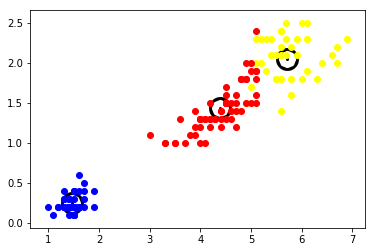

In [22]:
# plotting a 2D graph for any two dimensions. Dimensions can be chosen from 0-3.
dimensions = [2,3]
for centroid in clf.centroids:
    plt.scatter(clf.centroids[centroid][dimensions[0]], clf.centroids[centroid][dimensions[1]], color='black', marker='.', linewidth=20)

colors = ['blue','red','yellow'] # different colors for clusters
for classification in clf.classifications:
    for features in clf.classifications[classification]:
        plt.scatter(features[dimensions[0]], features[dimensions[1]], color=colors[2-classification])

plt.show()

## Expectation Maximization using Gaussian Mixture Models

In [12]:
import math

In [15]:
class GaussianMixtureModel():
    
    def __init__(self, k=3, max_iterations=2000, tolerance=1e-8):
        self.k = k
        self.parameters = []
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.responsibilities = []
        self.sample_assignments = None
        self.responsibility = None

    def init_random_gaussians(self, X):
        n_samples = np.shape(X)[0]
        self.priors = (1 / self.k) * np.ones(self.k)
        for i in range(self.k):
            params = {}
            params["mean"] = X[np.random.choice(range(n_samples))]
            params["cov"] = np.cov(X.T)
            self.parameters.append(params)
    
    def converged(self, X):
        if len(self.responsibilities) < 2:
            return False
        diff = np.linalg.norm(self.responsibilities[-1] - self.responsibilities[-2])
        return diff <= self.tolerance
    
    def expectation(self, X):
        weighted_likelihoods = self.get_likelihoods(X) * self.priors
        sum_likelihoods = np.expand_dims(np.sum(weighted_likelihoods, axis=1), axis=1)
        self.responsibility = weighted_likelihoods / sum_likelihoods
        self.sample_assignments = self.responsibility.argmax(axis=1) # Assigning samples to cluster that has largest probability
        self.responsibilities.append(np.max(self.responsibility, axis=1))  # Saving value to chech for convergence

    def maximization(self, X):
        for i in range(self.k): # Iterate through clusters and recalculate mean and covariance
            resp = np.expand_dims(self.responsibility[:, i], axis=1)
            mean = (resp * X).sum(axis=0) / resp.sum()
            covariance = (X - mean).T.dot((X - mean) * resp) / resp.sum()
            self.parameters[i]["mean"], self.parameters[i]["cov"] = mean, covariance

        n_samples = np.shape(X)[0]
        self.priors = self.responsibility.sum(axis=0) / n_samples   # Update weights accordingly

    def multivariate_gaussian(self, X, params):
        n_features = np.shape(X)[1]
        mean = params["mean"]
        covar = params["cov"]
        determinant = np.linalg.det(covar)
        likelihoods = np.zeros(np.shape(X)[0])
        for i, sample in enumerate(X): # calculate likehood over all samples
            d = n_features
            coeff = (1.0 / (math.pow((2.0 * math.pi), d / 2) * math.sqrt(determinant)))
            exponent = math.exp(-0.5 * (sample - mean).T.dot(np.linalg.pinv(covar)).dot((sample - mean)))
            likelihoods[i] = coeff * exponent

        return likelihoods

    def get_likelihoods(self, X):
        n_samples = np.shape(X)[0]
        likelihoods = np.zeros((n_samples, self.k))
        for i in range(self.k): # Calculating probabilities of X belonging to the different clusters
            likelihoods[:, i] = self.multivariate_gaussian(X, self.parameters[i])
        return likelihoods

    def fit_predict(self, X):
        self.init_random_gaussians(X) # Initialize the gaussians randomly

        for i in range(self.max_iterations): # Performing expectation maximization
            self.expectation(X)
            self.maximization(X)

            if self.converged(X): # Break if values have converged
                break
                
        self.expectation(X)
        return self.sample_assignments # Return the assigned clusters

In [16]:
gmm = GaussianMixtureModel()
gmm.fit_predict(data)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0,
       2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [18]:
clusters = gmm.fit_predict(data)
y_pred = np.copy(clusters) # as we can see from the above cell the first cluster is given the number 1 while the
y_pred[clusters == 1] = 0  # second cluster is given the number 0. Hence we swap these labels before calculating
y_pred[clusters == 0] = 1  # the accuracy

In [19]:
print("Accuracy - " + str(accuracy_score(y_pred,target)))

Accuracy - 0.82


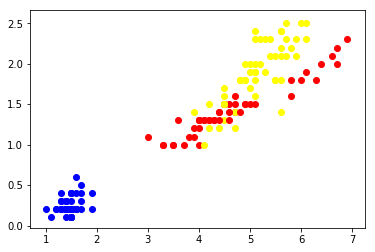

In [21]:
# plotting a 2D graph for any two dimensions. Dimensions can be chosen from 0-3.
dimensions = [2,3]

colors = ['blue','red','yellow'] # different colors for clusters
for i,x in enumerate(data):
    plt.scatter(x[dimensions[0]],x[dimensions[1]], color = colors[y_pred[i]])
plt.show()

## Mean Shift Clustering

In [23]:
class Mean_Shift:
    def __init__(self, radius=1.6):
        self.radius = radius

    def fit(self, data):
        centroids = {}

        for i in range(len(data)):
            centroids[i] = data[i] # initialize centroids
        
        while True:
            new_centroids = []
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                for featureset in data:
                    if np.linalg.norm(featureset-centroid) < self.radius: # form cluster of all points within this fixed radius
                        in_bandwidth.append(featureset)

                new_centroid = np.average(in_bandwidth,axis=0)
                new_centroids.append(tuple(new_centroid))

            uniques = sorted(list(set(new_centroids))) # keep removing centroid which have same points in their radius

            prev_centroids = dict(centroids)

            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])

            optimized = True

            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]): # stop when all similar clusters have been removed
                    optimized = False
                if not optimized:
                    break
                
            if optimized:
                break

        self.centroids = centroids
        
    def predict(self, data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

In [24]:
clf = Mean_Shift()
clf.fit(data)

In [25]:
centroids = clf.centroids
print(centroids)

{0: array([5.006, 3.418, 1.464, 0.244]), 1: array([6.17209302, 2.86627907, 4.80930233, 1.65813953]), 2: array([6.18390805, 2.87011494, 4.82298851, 1.65977011]), 3: array([6.18953488, 2.87325581, 4.83837209, 1.66744186])}


In [26]:
del(clf.centroids[3]) # as we can see from the coordinates, cluster number 3 is almost a copy of cluster 2 and we need only 3 clusters hence we discard it.

In [27]:
y_pred = []
for x in data:
    y_pred.append(clf.predict(x))

In [28]:
print("Accuracy - " + str(accuracy_score(y_pred,target)))

Accuracy - 0.8733333333333333


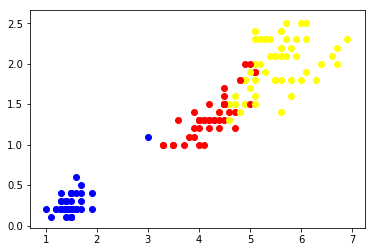

In [29]:
# plotting a 2D graph for any two dimensions. Dimensions can be chosen from 0-3.
dimensions = [2,3]

colors = ['blue','red','yellow'] # different colors for clusters
for i,x in enumerate(data):
    plt.scatter(x[dimensions[0]],x[dimensions[1]], color = colors[y_pred[i]])
plt.show()